In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram

import tensorflow as tf
import tensorflow.keras.backend as K
import pandas

from timbral_models import filter_audio_highpass, tf_filter_audio_highpass, timbral_util

%matplotlib inline

In [2]:
from timbral_models import timbral_brightness, tf_timbral_brightness

## Test filtrage passe-bas

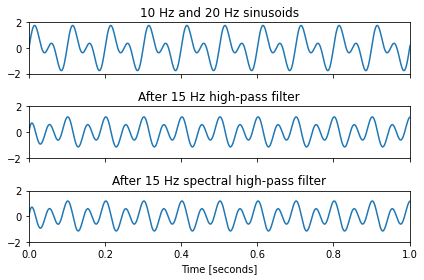

In [3]:
t = np.linspace(0, 16, 16000, False, dtype = np.float32)  # 16 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])

#Filtering with scipy
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')

filtered = filter_audio_highpass(sig, 15, fs = 1000, order=2)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])

# Filtering with Tensorflow
tf_sig = tf.expand_dims(tf.expand_dims(sig,0),-1)
y = tf_filter_audio_highpass(tf_sig, 15, fs = 1000, order=2, frame_length = 2048, frame_step= 256)
ax3.plot(t, y[0,: 16000])
ax3.set_title('After 15 Hz spectral high-pass filter')
ax3.axis([0, 1, -2, 2])
ax3.set_xlabel('Time [seconds]')

plt.tight_layout()
plt.show()

### Test meilleurs paramètres

In [4]:
filtered_reference = filter_audio_highpass(sig, 15, fs = 1000, order=2)
overlap = [0.25,0.5,0.75]
window = [2**i for i in range(7,15)]
results = []
# Filtering with Tensorflow
for i, overlap_value in enumerate(overlap):
    results.append([])
    for j, window_size in enumerate(window):
        y = tf_filter_audio_highpass(tf_sig, 15, fs = 1000, order=2, frame_length = window_size, frame_step= int        ((1-overlap_value)*window_size))
        error = np.mean((y[0]-filtered_reference)**2)
        results[i].append(error)
        #print(int((overlap_value)*100), window_size, error*100)

pandas.DataFrame(results, overlap, window)


,128,256,512,1024,2048,4096,8192,16384
0.25,1.039260,0.971066,0.932703,0.925660,0.922661,0.922365,0.922557,0.922317
0.50,0.860838,0.904527,0.917084,0.920777,0.922183,0.922521,0.922671,0.922752
0.75,0.843998,0.898314,0.915160,0.920266,0.921890,0.922435,0.922652,0.922746


## Test compatibilité spectrogrammes

In [5]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from timbral_models import timbral_util

In [6]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
x = carrier

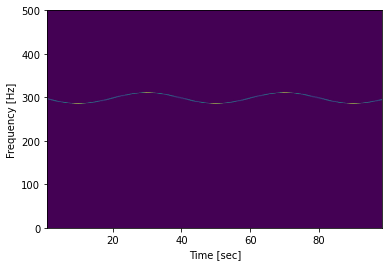

"\nN = np.sum(tf.signal.hamming_window(\n    nfft, periodic=True, dtype=tf.dtypes.float32, name=None\n))\nff, tt, Sxx_t = timbral_util.compat_spectrogram(x, 1000, 'hamming', nfft, hop_size, nfft, 'constant', True, 'spectrum')\nSxx_t = tf.transpose(Sxx_t,[1,0])\ncalc = (np.abs(Sxx_t.numpy())/N)**2\n"

In [7]:
nfft, hop_size = 2048,1024
fs = 1000

f, t, Sxx = signal.spectrogram(x, 1000, 'hamming', nfft, hop_size, nfft, False, True, 'spectrum')
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

nfft, hop_size = 2048,1024
fs = 1000
"""
N = np.sum(tf.signal.hamming_window(
    nfft, periodic=True, dtype=tf.dtypes.float32, name=None
))
ff, tt, Sxx_t = timbral_util.compat_spectrogram(x, 1000, 'hamming', nfft, hop_size, nfft, 'constant', True, 'spectrum')
Sxx_t = tf.transpose(Sxx_t,[1,0])
calc = (np.abs(Sxx_t.numpy())/N)**2
"""

In [8]:
np.max(Sxx)

3.9467882530412575

In [9]:
np.max(Sxx)

3.9467882530412575

In [10]:
x.shape[-1]

100000

## Test desripteur "Brightness"

## Test filtrage -- OK (erreur <1e-5)

In [11]:
fname ="/home/ubuntu/Documents/code/data/drummer_1_3_sd_001_hits_snare-drum_sticks_x6.wav"
audio_samples, fs = timbral_util.file_read(
        fname, 0, phase_correction=False)
audio_samples_t = tf.expand_dims(tf.convert_to_tensor(
    audio_samples, dtype = tf.float32),0)
audio_samples_t =  tf.expand_dims(audio_samples_t,-1)

/home/ubuntu/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


In [12]:
audio_samples_t

<tf.Tensor: shape=(1, 93184, 1), dtype=float32, numpy=
array([[[7.6417542e-05],
        [1.5283508e-04],
        [7.6417542e-05],
        ...,
        [0.0000000e+00],
        [7.6417542e-05],
        [7.6417542e-05]]], dtype=float32)>

In [13]:
minFreq = 20
ratio_crossover = 2000
centroid_crossover=100

# Filtrage normal

filtered = timbral_util.filter_audio_highpass(
    audio_samples, crossover=minFreq, fs=fs)
filtered = timbral_util.filter_audio_highpass(
    filtered, crossover=minFreq, fs=fs)
filtered = timbral_util.filter_audio_highpass(
    filtered, crossover=minFreq, fs=fs)


with tf.GradientTape() as g:
    # Filtrage TF
    g.watch(audio_samples_t)
    filtered_tf = timbral_util.tf_filter_audio_highpass(
        audio_samples_t, crossover=minFreq, fs=fs)
    filtered_tf = timbral_util.tf_filter_audio_highpass(
        filtered_tf, crossover=minFreq, fs=fs)

    filtered_tf = timbral_util.tf_filter_audio_highpass(
        filtered_tf, crossover=minFreq, fs=fs)
    
print(g.gradient(filtered_tf, audio_samples_t)
)
print(filtered_tf)


filtered_error = np.mean(np.abs(filtered - filtered_tf[:,:,0]))

tf.Tensor(
[[[-1.1063455e-05]
  [-1.0975483e-05]
  [-1.1020511e-05]
  ...
  [ 9.7003531e-01]
  [ 9.8198277e-01]
  [ 9.9400073e-01]]], shape=(1, 93184, 1), dtype=float32)
tf.Tensor(
[[[7.5961412e-05]
  [1.5103885e-04]
  [7.3129588e-05]
  ...
  [3.1982746e-04]
  [3.8883396e-04]
  [3.8100767e-04]]], shape=(1, 93184, 1), dtype=float32)


In [14]:
ratio_highpass_audio = timbral_util.filter_audio_highpass(
    audio_samples, ratio_crossover, fs)
ratio_highpass_audio = timbral_util.filter_audio_highpass(
    ratio_highpass_audio, ratio_crossover, fs)
ratio_highpass_audio = timbral_util.filter_audio_highpass(
    ratio_highpass_audio, ratio_crossover, fs)

ratio_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    audio_samples_t, ratio_crossover, fs)
ratio_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    ratio_highpass_audio_t, ratio_crossover, fs)
ratio_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    ratio_highpass_audio_t, ratio_crossover, fs)


ratio_filtered_error = np.mean(np.abs(ratio_highpass_audio - ratio_highpass_audio_t[:,:,0]))

In [15]:
# get highpass audio at centroid crossover
centroid_highpass_audio = timbral_util.filter_audio_highpass(
    audio_samples, centroid_crossover, fs)
centroid_highpass_audio = timbral_util.filter_audio_highpass(
    centroid_highpass_audio, centroid_crossover, fs)
centroid_highpass_audio = timbral_util.filter_audio_highpass(
    centroid_highpass_audio, centroid_crossover, fs)

# get highpass audio at centroid crossover
centroid_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    audio_samples_t, centroid_crossover, fs)
centroid_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    centroid_highpass_audio_t, centroid_crossover, fs)
centroid_highpass_audio_t = timbral_util.tf_filter_audio_highpass(
    centroid_highpass_audio_t, centroid_crossover, fs)

centroid_filtered_error = np.mean(np.abs(centroid_highpass_audio - centroid_highpass_audio_t[:,:,0]))

In [16]:
filtered_error, ratio_filtered_error, centroid_filtered_error

(1.7587826e-06, 6.1720095e-07, 5.657774e-06)

## Spectrograms

### Normalization -- OK

In [17]:
ratio_highpass_audio,ratio_highpass_audio_t

ratio_highpass_audio_norm = (1.0 / max(abs(audio_samples))) * ratio_highpass_audio
centroid_highpass_audio_norm = centroid_highpass_audio * (1.0 / max(abs(audio_samples)))
audio_samples_norm = audio_samples* (1.0 / max(abs(audio_samples)))


ratio_highpass_audio_norm_t = ratio_highpass_audio_t * \
    (1.0 / K.max(K.abs(audio_samples_t), axis=1))

centroid_highpass_audio_norm_t = centroid_highpass_audio_t * \
    (1.0 / K.max(K.abs(audio_samples_t), axis=1))
audio_samples_norm_t = audio_samples_t * (1.0 / K.max(K.abs(audio_samples_t), axis=1))

ratio_error = ratio_highpass_audio_norm - ratio_highpass_audio_norm_t[:,:,0]
centroid_error = centroid_highpass_audio_norm_t[:,:,0] - centroid_highpass_audio_norm
audio_error = audio_samples_norm - audio_samples_norm_t[:,:,0]

In [18]:
np.mean(np.abs(audio_error)), np.mean(np.abs(ratio_error)), np.mean(np.abs(centroid_error)), 

(0.0, 6.1720095e-07, 5.657774e-06)

### Spectrogram

In [19]:
blockSize = 2048
nfft = blockSize
hop_size = int(3 * nfft / 4)

In [20]:
ratio_all_freq, ratio_all_time, ratio_all_spec = spectrogram(audio_samples, fs, 'hamming', nfft,
                                                             hop_size, nfft, 'constant', True, 'spectrum')
ratio_hp_freq, ratio_hp_time, ratio_hp_spec = spectrogram(ratio_highpass_audio, fs, 'hamming', nfft,
                                                          hop_size, nfft, 'constant', True, 'spectrum')
centroid_hp_freq, centroid_hp_time, centroid_hp_spec = spectrogram(centroid_highpass_audio, fs, 'hamming', nfft,
                                                                   hop_size, nfft, 'constant', True, 'spectrum')

In [21]:
with tf.GradientTape(persistent = False) as g:
    g.watch(audio_samples_norm_t)
    r = timbral_util.compat_spectrogram(audio_samples_norm_t, fs, 'hamming', nfft,
                                                             hop_size, nfft, 'constant', True, 'spectrum')
    
dy_dx = g.gradient(r, audio_samples_norm_t)
print(dy_dx)


tf.Tensor(
[[[ 1.2052489e-07]
  [ 1.2395212e-07]
  [ 1.2053214e-07]
  ...
  [-2.4739590e-09]
  [-1.1446437e-09]
  [-8.3546081e-10]]], shape=(1, 93184, 1), dtype=float32)


In [22]:

r


(<tf.Tensor: shape=(1025,), dtype=float32, numpy=
 array([0.0000000e+00, 2.1533203e+01, 4.3066406e+01, ..., 2.2006934e+04,
        2.2028467e+04, 2.2050000e+04], dtype=float32)>,
 <tf.Tensor: shape=(179,), dtype=float32, numpy=
 array([0.03482993, 0.06965987, 0.1044898 , 0.13931973, 0.17414966,
        0.20897959, 0.24380952, 0.27863947, 0.31346938, 0.34829932,
        0.38312924, 0.41795918, 0.45278913, 0.48761904, 0.52244896,
        0.55727893, 0.59210885, 0.62693876, 0.66176873, 0.69659865,
        0.73142856, 0.7662585 , 0.80108845, 0.83591837, 0.8707483 ,
        0.90557826, 0.9404082 , 0.9752381 , 1.010068  , 1.0448979 ,
        1.0797279 , 1.1145579 , 1.1493877 , 1.1842177 , 1.2190477 ,
        1.2538775 , 1.2887075 , 1.3235375 , 1.3583673 , 1.3931973 ,
        1.4280272 , 1.4628571 , 1.4976871 , 1.532517  , 1.5673469 ,
        1.6021769 , 1.6370068 , 1.6718367 , 1.7066667 , 1.7414966 ,
        1.7763265 , 1.8111565 , 1.8459864 , 1.8808163 , 1.9156463 ,
        1.9504762 , 1.98

In [23]:
print(np.shape(ratio_all_spec), ratio_all_spec_t.shape)
print(np.shape(ratio_hp_spec), ratio_hp_spec_t.shape)
print(np.shape(centroid_hp_spec), centroid_hp_spec_t.shape)

NameError: name 'ratio_all_spec_t' is not defined

## Calcul

### AudioCommons

In [ ]:
# initialise variables for storing data
all_ratio = []
all_hp_centroid = []
all_tpower = []
all_hp_centroid_tpower = []
threshold = 0.

# set threshold level at zero
threshold_db = threshold
if threshold_db == 0:
    threshold = 0
    hp_threshold = 0
else:
    print("threshold non zero")
    max_power = max(np.sum(ratio_all_spec, axis=1))
    threshold = max_power * timbral_util.db2mag(threshold_db)
    # get the threshold for centroid
    # centroid_hp_max_power = max(np.sum(centroid_hp_spec, axis=1))
    # hp_min_power = min(np.sum(hp_spec, axis=1))
    # hp_threshold = hp_max_power * timbral_util.db2mag(threshold_db)
# threshold = 0.0

'''
  Calculate features for each time window
'''
for idx in range(len(ratio_hp_time)):  #
    # get the current spectrum for this time window
    current_ratio_hp_spec = ratio_hp_spec[:, idx]
    current_ratio_all_spec = ratio_all_spec[:, idx]
    current_centroid_hp_spec = centroid_hp_spec[:, idx]

    # get the power within each spectrum
    tpower = np.sum(current_ratio_all_spec)
    hp_tpower = np.sum(current_ratio_hp_spec)
    # check there is energy in the time window before calculating the ratio (greater than 0)
    if tpower > threshold:
        # get the ratio
        all_ratio.append(hp_tpower / tpower)
        # store the powef for weighting
        all_tpower.append(tpower)

    # get the tpower to assure greater than zero
    hp_centroid_tpower = np.sum(current_centroid_hp_spec)
    if hp_centroid_tpower > 0.0:
        # get the centroid
        all_hp_centroid.append(np.sum(current_centroid_hp_spec * centroid_hp_freq[:len(current_centroid_hp_spec)]) /
                               np.sum(current_centroid_hp_spec))
        # store the tpower for weighting
        all_hp_centroid_tpower.append(hp_centroid_tpower)

'''
  Get mean and weighted average values
'''
mean_ratio = np.mean(all_ratio)
mean_hp_centroid = np.mean(all_hp_centroid)

print(np.sum(all_ratio))
acm_score = (mean_ratio, mean_hp_centroid)
acm_score


### Tensorflow

In [ ]:
if threshold == 0.:
    # get the current spectrum for this time window
    """
    Original :
    current_ratio_hp_spec = ratio_hp_spec[:, idx]
    current_ratio_all_spec = ratio_all_spec[:, idx]
    current_centroid_hp_spec = centroid_hp_spec[:, idx]
    Note :
    compat_spectrogram sort le spectrogramme "à l'envers". 
    On aura current_centroid_hp_spec = centroid_hp_spec[idx, :] en fait
    Cela induit l'utilisation de axis 0 (ou 1 ?)
    current_ratio_hp_spec = ratio_hp_spec_t[:, idx]
    current_ratio_all_spec = ratio_all_spec_t[:, idx]
    current_centroid_hp_spec = centroid_hp_spec_t[:, idx]
    """
    # get the power within each spectrum
    tpower = K.sum(ratio_all_spec_t, axis = -1)
    hp_tpower = K.sum(ratio_hp_spec_t, axis = -1)
    # check there is energy in the time window before calculating the ratio (greater than 0)
    """
    if tpower > threshold:
        # get the ratio
        all_ratio.append(hp_tpower / tpower)
        # store the powef for weighting
        all_tpower.append(tpower)
    """
    # Threshold is always 0. : the if is useless
    # get the ratio
    all_ratio_t = hp_tpower / tpower
    # store the powef for weighting
    all_tpower_t = (tpower)
    # get the tpower to assure greater than zero
    hp_centroid_tpower_t = tf.reduce_sum(
        centroid_hp_spec_t, axis=-1)

    # if hp_centroid_tpower > 0.0:
        # get the centroid
    """
    all_hp_centroid.append(np.sum(current_centroid_hp_spec * centroid_hp_freq[:len(current_centroid_hp_spec)]) /
                    np.sum(current_centroid_hp_spec))
    """
    #print("centroid_hp_spec", centroid_hp_spec)
    #print("centroid_hp_freq", centroid_hp_freq)
    assert tf.rank(centroid_hp_spec_t) == 3
    all_hp_centroid_t = tf.reduce_sum(centroid_hp_spec_t * centroid_hp_freq[None,None,:], axis=-1) \
    / tf.reduce_sum(centroid_hp_spec_t, axis=-1)
    # store the tpower for weighting
    all_hp_centroid_tpower_t = (hp_centroid_tpower_t)
else:
    raise NotImplemented

'''
Get mean and weighted average values
'''
#all_tpower_t :: OK
with tf.GradientTape() as g:
    g.watch(hp_tpower)
    mean_ratio_t = K.mean(all_ratio_t, axis=None)
    mean_hp_centroid_t = K.mean(all_hp_centroid_t, axis=None)
    mean_ratio_t, mean_hp_centroid_t
dy_dx = g.gradient(mean_ratio_t, hp_tpower) 
print(dy_dx)

In [ ]:
np.average(all_ratio, weights=all_tpower)
weighted_mean_ratio = K.sum(all_ratio_t * all_tpower_t)/K.sum(all_tpower_t)

In [ ]:
np.average(all_hp_centroid, weights=all_hp_centroid_tpower)
weighted_mean_hp_centroid = K.sum(all_hp_centroid_t * all_hp_centroid_tpower_t)/K.sum(all_hp_centroid_tpower_t)
        

In [ ]:
# perform thye linear regression
all_metrics = np.ones(3)
all_metrics[0] = np.log10(weighted_mean_ratio)
all_metrics[1] = np.log10(weighted_mean_hp_centroid)
# all_metrics[2] = np.log10(weighted_mean_ratio) * np.log10(weighted_mean_hp_centroid)
print(all_metrics)
coefficients = np.array(
    [4.613128018020465, 17.378889309312974, 17.434733750553022])

# coefficients = np.array([-2.9197705625030235, 9.048261758526614, 3.940747859061009, 47.989783427908705])
bright = np.sum(all_metrics * coefficients)
bright

In [ ]:
base = tf.cast(tf.math.log(10.), weighted_mean_ratio.dtype)
print(tf.math.log(weighted_mean_ratio)/base)
all_metrics = tf.Variable([tf.math.log(weighted_mean_ratio)/base,
                           tf.math.log(weighted_mean_hp_centroid) /
                           base, 1.
                           ])
print(all_metrics)
# all_metrics[2] = np.log10(weighted_mean_ratio) * np.log10(weighted_mean_hp_centroid)

coefficients = tf.constant(
    [4.613128018020465, 17.378889309312974, 17.434733750553022], dtype=all_metrics.dtype)

# coefficients = np.array([-2.9197705625030235, 9.048261758526614, 3.940747859061009, 47.989783427908705])
bright = K.sum(all_metrics * coefficients)

bright


### Tensorflow itératif

In [ ]:
all_ratio = []
all_hp_centroid = []
all_tpower = []
all_hp_centroid_tpower = []

# set threshold level at zero
# threshold in an ununsed parameter
threshold = 0.0


for idx in range(len(ratio_hp_time)):  #
    # get the current spectrum for this time window
    current_ratio_hp_spec = ratio_hp_spec_t[0,idx]
    current_ratio_all_spec = ratio_all_spec_t[0,idx]
    current_centroid_hp_spec = centroid_hp_spec_t[0,idx]

    # get the power within each spectrum
    tpower = np.sum(current_ratio_all_spec)
    hp_tpower = np.sum(current_ratio_hp_spec)
    # check there is energy in the time window before calculating the ratio (greater than 0)
    if tpower > threshold:
        # get the ratio
        all_ratio.append(hp_tpower / tpower)
        # store the powef for weighting
        all_tpower.append(tpower)

    # get the tpower to assure greater than zero
    hp_centroid_tpower = np.sum(current_centroid_hp_spec)
    if hp_centroid_tpower > 0.0:
        # get the centroid
        all_hp_centroid.append(np.sum(current_centroid_hp_spec * centroid_hp_freq[:len(current_centroid_hp_spec)]) /
                               np.sum(current_centroid_hp_spec))
        # store the tpower for weighting
        all_hp_centroid_tpower.append(hp_centroid_tpower)
        
mean_ratio = np.mean(all_ratio)
mean_hp_centroid = np.mean(all_hp_centroid)

mean_ratio, mean_hp_centroid

### Moyennage

In [ ]:
K.sum(all_ratio_t * all_tpower_t)/K.sum(all_tpower_t)


## Propagation des gradients

In [ ]:
def tf_test(audio_samples, fs=0, dev_output=False, clip_output=False, phase_correction=None, threshold=None,
                          ratio_crossover=2000, centroid_crossover=100, stepSize=1024, blockSize=2048, minFreq=20):
    assert tf.rank(audio_samples) == 3, "Should be BNC at the input"

    # highpass audio at minimum frequency
    audio_samples = timbral_util.tf_filter_audio_highpass(
        audio_samples, crossover=minFreq, fs=fs)
    audio_samples = timbral_util.tf_filter_audio_highpass(
        audio_samples, crossover=minFreq, fs=fs)
    audio_samples = timbral_util.tf_filter_audio_highpass(
        audio_samples, crossover=minFreq, fs=fs)

    # get highpass audio at ratio crossover
    ratio_highpass_audio = timbral_util.tf_filter_audio_highpass(
        audio_samples, ratio_crossover, fs)
    ratio_highpass_audio = timbral_util.tf_filter_audio_highpass(
        ratio_highpass_audio, ratio_crossover, fs)
    ratio_highpass_audio = timbral_util.tf_filter_audio_highpass(
        ratio_highpass_audio, ratio_crossover, fs)

    # get highpass audio at centroid crossover
    centroid_highpass_audio = timbral_util.tf_filter_audio_highpass(
        audio_samples, centroid_crossover, fs)
    centroid_highpass_audio = timbral_util.tf_filter_audio_highpass(
        centroid_highpass_audio, centroid_crossover, fs)
    centroid_highpass_audio = timbral_util.tf_filter_audio_highpass(
        centroid_highpass_audio, centroid_crossover, fs)

    assert tf.rank(audio_samples) == 3, audio_samples
    '''
    Get spectrograms
    '''
    # normalise audio to the maximum value in the unfiltered audio
    ratio_highpass_audio = ratio_highpass_audio * \
        (1.0 / K.max(K.abs(audio_samples), axis=1))
    centroid_highpass_audio = centroid_highpass_audio * \
        (1.0 / K.max(K.abs(audio_samples), axis=1))
    audio_samples = audio_samples * (1.0 / K.max(K.abs(audio_samples), axis=1))


    # set FFT parameters
    nfft = blockSize
    hop_size = int(3 * nfft / 4)

    # check that audio is long enough to generate spectrograms
    if audio_samples.shape[1] >= nfft:
        # get spectrogram
        ratio_all = timbral_util.compat_spectrogram(audio_samples, fs, 'hamming', nfft,
                                                                                         hop_size, nfft, 'constant', True, 'spectrum')
        ratio_all_freq, ratio_all_time, ratio_all_spec = ratio_all
        ratio_hp = timbral_util.compat_spectrogram(ratio_highpass_audio, fs, 'hamming', nfft,
                                                                                      hop_size, nfft, 'constant', True, 'spectrum')
        ratio_hp_freq, ratio_hp_time, ratio_hp_spec = ratio_hp
        centroid_hp = timbral_util.compat_spectrogram(centroid_highpass_audio, fs, 'hamming', nfft,
                                                                                               hop_size, nfft, 'constant', True, 'spectrum')
        centroid_hp_freq, centroid_hp_time, centroid_hp_spec = centroid_hp
    else:
        exit()
        ratio_all_freq, ratio_all_time, ratio_all_spec = timbral_util.compat_spectrogram(audio_samples, fs, 'hamming',
                                                                                         len(
                                                                                             audio_samples),
                                                                                         len(
                                                                                             audio_samples)-1,
                                                                                         nfft, 'constant', True, 'spectrum')
        ratio_hp_freq, ratio_hp_time, ratio_hp_spec = timbral_util.compat_spectrogram(ratio_highpass_audio, fs, 'hamming',
                                                                                      len(
                                                                                          ratio_highpass_audio),
                                                                                      len(
                                                                                          ratio_highpass_audio)-1,
                                                                                      nfft, 'constant', True, 'spectrum')
        centroid_hp_freq, centroid_hp_time, centroid_hp_spec = timbral_util.compat_spectrogram(centroid_highpass_audio, fs, 'hamming',
                                                                                               len(
                                                                                                   centroid_highpass_audio),
                                                                                               len(
                                                                                                   centroid_highpass_audio)-1,
                                                                                               nfft, 'constant', True, 'spectrum')
    #print(ratio_all_time.shape, ratio_hp_time.shape, centroid_hp_time.shape)
    # initialise variables for storing data
    all_ratio = []
    all_hp_centroid = []
    all_tpower = []
    all_hp_centroid_tpower = []

    
    # set threshold level at zero
    # threshold in an ununsed parameter
    threshold = 0.0

    '''
    Calculate features for each time window
    '''
    # TODO :: temporary fix-it

    if threshold == 0.:
        for idx in range(len(ratio_hp_time)):  #
            pass
        # get the current spectrum for this time window
        """
        Original :
        current_ratio_hp_spec = ratio_hp_spec[:, idx]
        current_ratio_all_spec = ratio_all_spec[:, idx]
        current_centroid_hp_spec = centroid_hp_spec[:, idx]
        Note :
        compat_spectrogram sort le spectrogramme "à l'envers". 
        On aura current_centroid_hp_spec = centroid_hp_spec[idx, :] en fait
        Cela induit l'utilisation de axis 0 (ou 1 ?)
        """
        current_ratio_hp_spec = ratio_hp_spec[:, idx]
        current_ratio_all_spec = ratio_all_spec[:, idx]
        current_centroid_hp_spec = centroid_hp_spec[:, idx]
        # get the power within each spectrum
        tpower = K.sum(ratio_all_spec, axis=-1)
        hp_tpower = K.sum(ratio_hp_spec, axis=-1)
        # check there is energy in the time window before calculating the ratio (greater than 0)
        """
        if tpower > threshold:
            # get the ratio
            all_ratio.append(hp_tpower / tpower)
            # store the powef for weighting
            all_tpower.append(tpower)
        """
        # Threshold is always 0. : the if is useless
        # get the ratio
        all_ratio = hp_tpower / tpower
        # store the powef for weighting
        all_tpower = tpower
        # get the tpower to assure greater than zero
        hp_centroid_tpower = K.sum(
            centroid_hp_spec, axis=-1)
        # if hp_centroid_tpower > 0.0:
        # get the centroid
        """
        all_hp_centroid.append(np.sum(current_centroid_hp_spec * centroid_hp_freq[:len(current_centroid_hp_spec)]) /
                        np.sum(current_centroid_hp_spec))
        """
        #print("centroid_hp_spec", centroid_hp_spec)
        #print("centroid_hp_freq", centroid_hp_freq)
        all_hp_centroid = tf.reduce_sum(
            centroid_hp_spec * centroid_hp_freq[None, None, :], axis=-1) / tf.reduce_sum(centroid_hp_spec, axis=-1)
        # store the tpower for weighting
        all_hp_centroid_tpower = (hp_centroid_tpower)
    else:
        raise NotImplemented
    '''
    Get mean and weighted average values
    '''
    mean_ratio = K.mean(all_ratio, axis=-1)

    mean_hp_centroid = K.mean(all_hp_centroid, axis=-1)


    # Différence pas bien élevée :: job done.

    # TODO :: operation should be batch compatible.
    weighted_mean_ratio = K.sum(all_ratio * all_tpower, axis = -1)/K.sum(all_tpower, axis = -1)
    weighted_mean_hp_centroid = K.sum(
        all_hp_centroid * all_hp_centroid_tpower, axis = -1)/K.sum(all_hp_centroid_tpower, axis = -1)
    print("all_ratio", weighted_mean_ratio, weighted_mean_hp_centroid)

    base = tf.cast(tf.math.log(10.), dtype=weighted_mean_ratio.dtype)
    print("scores : ", tf.math.log(weighted_mean_ratio)/base, tf.math.log(weighted_mean_hp_centroid)/base )
    if dev_output:
        # return the ratio and centroid
        return tf.math.log(weighted_mean_ratio)/base, tf.math.log(weighted_mean_hp_centroid)/base
        # eturn mean_ratio, mean_hp_centroid
    else:
        # perform thye linear regression
        """
   all_metrics = np.ones(3)
        all_metrics[0] = np.log10(weighted_mean_ratio)
        all_metrics[1] = np.log10(weighted_mean_hp_centroid)
        # all_metrics[2] = np.log10(weighted_mean_ratio) * np.log10(weighted_mean_hp_centroid)

        coefficients = np.array(
            [4.613128018020465, 17.378889309312974, 17.434733750553022])

        # coefficients = np.array([-2.9197705625030235, 9.048261758526614, 3.940747859061009, 47.989783427908705])
        bright = np.sum(all_metrics * coefficients)

        if clip_output:
            bright = timbral_util.output_clip(bright)
        """

        all_metrics = tf.Variable([tf.math.log(weighted_mean_ratio)/base,
                                   tf.math.log(weighted_mean_hp_centroid) /
                                   base, tf.ones_like(weighted_mean_ratio)])

        # all_metrics[2] = np.log10(weighted_mean_ratio) * np.log10(weighted_mean_hp_centroid)

        coefficients = tf.constant(
            [4.613128018020465, 17.378889309312974, 17.434733750553022], dtype=all_metrics.dtype)

        # coefficients = np.array([-2.9197705625030235, 9.048261758526614, 3.940747859061009, 47.989783427908705])
        # K.sum seems to give None gradients...
        #   17.434733750553022
        bright = K.sum(all_metrics * coefficients) 
        output = 4.613128018020465* tf.math.log(weighted_mean_ratio)/base \
        + 17.378889309312974 * tf.math.log(weighted_mean_hp_centroid) /base \
        + 17.434733750553022 * tf.ones_like(weighted_mean_hp_centroid)


        if clip_output:
            bright = timbral_util.output_clip(bright)
        print("bright",bright)
        print("output", output)
        return output

with tf.GradientTape() as g:
    g.watch(audio_samples_t)
    tf_score = tf_test(audio_samples_t, 44100)
    
dy_dx = g.gradient(tf_score, audio_samples_t)# Will compute to 6.0
print(dy_dx)

## Final

In [ ]:
acm_score = timbral_brightness(fname)

with tf.GradientTape() as g:
    g.watch(audio_samples_t)
    tf_score = tf_timbral_brightness(audio_samples_t, fs=fs)
dy_dx = g.gradient(tf_score, audio_samples_t)# Will compute to 6.0
print(dy_dx)

In [ ]:
(tf_score - acm_score)/acm_score * 100

In [ ]:
%run -i 'test_brightness.py'